# Model 2: Simple LSTM
    - A simple one LSTM recurent layer 


In [1]:
# Header
from __future__ import print_function

import numpy as np
import keras
print('Keras version: ', keras.__version__)

# GPU devices visible by python
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Limit memory usage
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))


path = '/home/ubuntu/data/training/keras/'

Using TensorFlow backend.


Keras version:  2.0.1


## Preprocess data

In [2]:
# Import train and test data
data_path='/home/ubuntu/data/training/keras/aclImdb/'

X_train = np.load(data_path+'X_train.npy')
y_train = np.load(data_path+'y_train.npy')
X_test = np.load(data_path+'X_test.npy')
y_test = np.load(data_path+'y_test.npy')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(25000, 200) (25000,)
(25000, 200) (25000,)


## Prepare sequences to model


In [3]:
max_features = 20000 # Number of most frequent words selected. the less frequent recode to 0
max_len = 100  # cut texts after this number of words (among top max_features most common words)


#Select the most frequent max_features, recode others using 0
def remove_features(x):
    return [[0 if w >= max_features else w for w in sen] for sen in x]

X_train = remove_features(X_train)
X_test  = remove_features(X_test)


# Cut or complete the sentences to length = maxlen
from keras.preprocessing import sequence

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=max_len)
X_test = sequence.pad_sequences(X_test, maxlen=max_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)


Pad sequences (samples x time)
X_train shape: (25000, 100)
X_test shape: (25000, 100)


## Build model

In [4]:
# Model
dim_embedings = 128 #Dimension of the embedings vector
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense, merge
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, ), dtype='int32') 

# LAYER 2: Create embedings
embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
rnn_out = LSTM(num_hidden_rnn, return_sequences=False, name='Forward')(embeds)

# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(inputs=seq_prev_input, outputs=output)
model_1.summary()

# Compile model and select optimizer
rms_optimizer = RMSprop(lr=0.001)
model_1.compile(loss='sparse_categorical_crossentropy', optimizer=rms_optimizer, metrics=['accuracy'])


Build model 1 - Basic model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
Forward (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 2,691,842.0
Trainable params: 2,691,842.0
Non-trainable params: 0.0
_________________________________________________________________


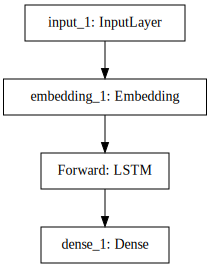

In [5]:
#Plot the model graph
from IPython.display import SVG
from keras.utils import vis_utils

SVG(vis_utils.model_to_dot(model_1).create(prog='dot', format='svg'))

In [6]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, epochs=10,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 37s - loss: 0.4989 - acc: 0.7574 - val_loss: 0.3835 - val_acc: 0.8308
Epoch 2/10
25000/25000 [==============================] - 37s - loss: 0.3059 - acc: 0.8741 - val_loss: 0.3792 - val_acc: 0.8342
Epoch 3/10
25000/25000 [==============================] - 36s - loss: 0.2384 - acc: 0.9062 - val_loss: 0.6434 - val_acc: 0.7784
Epoch 4/10
25000/25000 [==============================] - 36s - loss: 0.1914 - acc: 0.9262 - val_loss: 0.3917 - val_acc: 0.8364
Epoch 5/10
25000/25000 [==============================] - 36s - loss: 0.1557 - acc: 0.9414 - val_loss: 0.5946 - val_acc: 0.8250
Epoch 6/10
25000/25000 [==============================] - 36s - loss: 0.1240 - acc: 0.9547 - val_loss: 0.5117 - val_acc: 0.8331
Epoch 7/10
25000/25000 [==============================] - 36s - loss: 0.0967 - acc: 0.9655 - val_loss: 0.5865 - val_acc: 0.8215
Epoch 8/10
25000/25000 [=====================

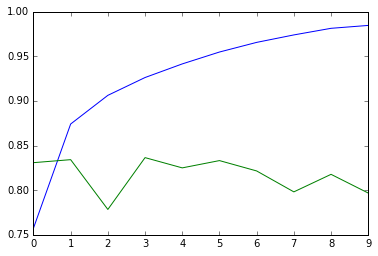

In [7]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [8]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


Accuracy:  0.79676
AUC:  0.882947264


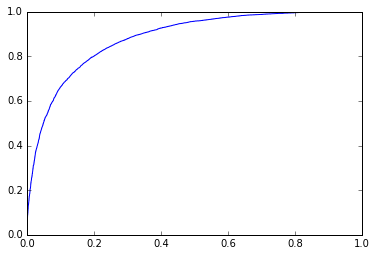

In [9]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Calculate accuracy with sklearn
print('Accuracy: ',accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print( 'AUC: ', auc(fpr, tpr))
#Plot ROC curve
plt.plot(fpr, tpr)

In [10]:
# Score new text

import pickle
with open(data_path + 'worddict.pickle', 'rb') as pfile:
    worddict = pickle.load(pfile)

    
def tokenize(sentences):
    from nltk import word_tokenize
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence)]
    return tokens


def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs


def remove_features(x):
    return [[0 if w >= max_features else w for w in sen] for sen in x]


def score_new_text(text):
    seq = generate_sequence(tokenize([text]), worddict)
    seq = remove_features(seq)
    seq = sequence.pad_sequences(seq, maxlen=max_len)
    pred_test = model_1.predict(seq, batch_size=1)
    return float(pred_test[:,1])


In [11]:
#Evaluate one negative record

text = "You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the full movie like i did."
print(text)
print('Positive score:', score_new_text(text))

You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the full movie like

In [12]:
#Evaluate one positive record

text = "The distribution was good, the subject could have been interessant and comic. whereas, he described the wandering of an old non credible communist looking for loving sensations. Instead of this, the atmosphere is nor lively nor heavy."
print(text)
print('Positive score:', score_new_text(text))

The distribution was good, the subject could have been interessant and comic. whereas, he described the wandering of an old non credible communist looking for loving sensations. Instead of this, the atmosphere is nor lively nor heavy.
Positive score: 0.9991970658302307
